In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from models import KuraNet
from train import optimize_connectivity_net
from data import make_data, make_all_data, make_data2
from utils import circular_variance, circular_moments, cohn_loss, make_masks
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Generate Data

In [7]:
from os.path import expanduser
home = expanduser("~")
data_base_dir = os.path.join(home,'cluster_synchrony1')
if not os.path.exists(data_base_dir): os.makedirs(data_base_dir)

num_samples=10000
data_names=['GMM_5']
dist_names = ['GMM']
num_classes=5
# dist_names = ['uniform1', 'uniform1', 'degenerate']
# dist_names = ['uniform2', 'degenerate', 'negative_binomial']

# Uncomment second and third lines if h and tau are not dirac distributions
make_data2(data_names[0], dist_names[0], data_base_dir=data_base_dir, num_samples=num_samples,num_classes=num_classes)
# make_data(dist_names[1], data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)
# make_data(dist_names[2], data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)

# make_all_data(num_samples=args.num_samples,data_dir=args.data_dir)

# Set Training Parameters (Fix gain)

In [8]:
seed=0
num_classes=5
model_type='xy'
num_samples=10000
num_epochs=5
num_units=100
batch_size=100
feature_dim=2
num_hid_units=128
symmetric=True
normalize=True
device='cuda'
adjoint=True
solver_method='euler'
optimizer='Adam'
max_grad_norm=1.0
lr=5e-5
momentum=0.0
loss_type='circular_moments'
alpha=15
gd_steps=100
burn_in_steps=0
measure_cx=False

num_batches = int(num_samples/num_units)

 # Set loss function
if loss_type == 'circular_variance':
    loss_func = circular_variance
elif loss_type == 'circular_moments':
    loss_func = circular_moments
elif loss_type == 'cohn_loss':
    loss_func = cohn_loss
else:
    raise Exception('Loss type not recognized.')


# Load training and testing data.
# Load training and testing data.
train_dls  = {}
test_dls   = {}

for dl, regime in zip([train_dls, test_dls], ['train', 'test']):
    for dist_name, data_name in zip(dist_names, data_names):
        if dist_name != 'degenerate':
            dt = np.load(os.path.join(data_base_dir, data_name, dist_name, regime, 'features.npz'))
            ds = TensorDataset(torch.FloatTensor(dt['x']), torch.LongTensor(dt['y'].astype(np.int32)))
        else:
            ds = TensorDataset(torch.zeros(num_samples).float(), torch.zeros(num_samples).long())
        dl[data_name] = DataLoader(ds, batch_size=num_units, shuffle=True, drop_last=True)
data_keys = [key for key in train_dls.keys()]

# Run Training

In [9]:
np.random.seed(seed)
torch.manual_seed(seed)

loss_train, loss_test, kn, cx = optimize_connectivity_net(num_units, feature_dim, train_dls, test_dls, model_type=model_type,
                                                          num_classes=num_classes, avg_deg=1.0, normalize=normalize,
                                                          pretrained=False, num_epochs=num_epochs,  batch_size=num_units, 
                                                          burn_in_steps=burn_in_steps, gd_steps=gd_steps,
                                                          alpha=alpha, solver_method=solver_method, adjoint=adjoint,
                                                          loss_type=loss_type, optimizer=optimizer,
                                                          lr=lr, momentum=momentum, max_grad_norm=max_grad_norm,
                                                          num_hid_units=num_hid_units, verbose=1, show_every=10,
                                                          num_eval_batches=10, rand_inds=False, device=device)


Training. Epoch 0.


TypeError: `t` must be a floating point Tensor but is a torch.cuda.LongTensor

# Visualization

Optimized loss: 0.1629


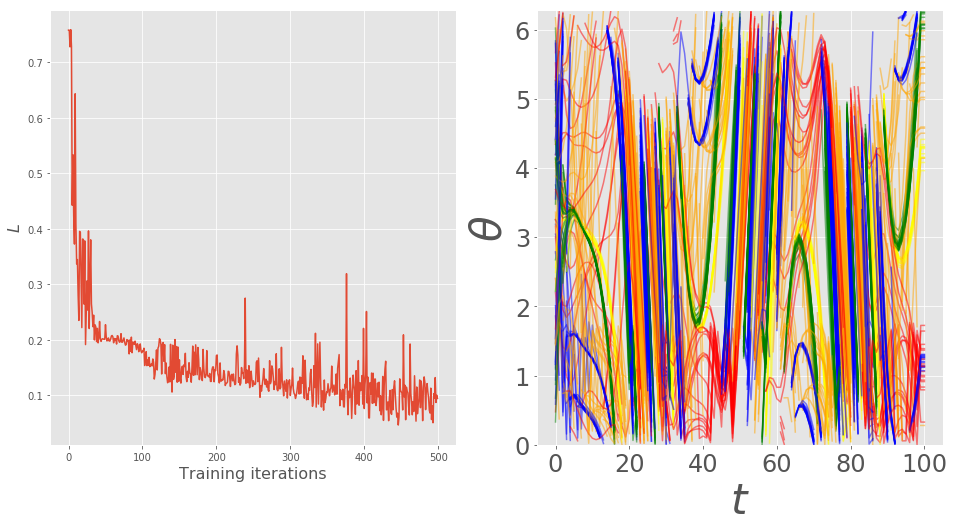

In [47]:
visualization_time=100

kn.set_grids(alpha, visualization_time, 1)

# Load one testing batch
for j, batch in enumerate(zip(*[test_dls[key] for key in data_keys])):
    X = {key : x.float().to(device) for (key, (x,_)) in zip(data_keys, batch)}
    Y = {key : y for (key, (_,y)) in zip(data_keys, batch)}
    # This is only used for cluster synchrony experiments
    if num_classes > 0:
        masks = make_masks(Y,num_classes,device)
    else:
        masks = None

    target = batch[0][1].numpy()
    # Fix max delay for memory problems
    if 'tau' in X.keys():
        X['tau']  = torch.where(X['tau'] > 40.0, 40.0 * torch.ones_like(X['tau']),X['tau'])
    break
    
# Sometimes animations look better if you increase the step size above that used during learning. 
kn.alpha= .01
# kn_control.alpha=1.0
flow = kn.run(X, full_trajectory=True)
print('Optimized loss: %.04f' % loss_func(flow[burn_in_steps:], masks=masks))

flow = flow.data.cpu().numpy() 

fig, axes = plt.subplots(1,2,figsize=(16,8))
all_colors = ['red', 'green', 'blue', 'orange', 'yellow', 'purple', 'pink', 'gray', 'black', 'magenta']

axes[0].plot(loss_train)
axes[0].set_xlabel('Training iterations', fontsize=16)
axes[0].set_ylabel(r'$L$', fontsize=16)

flow_colors = [all_colors[tg] for tg in target]

flow = (flow % ((2 * np.pi) + 2 * np.pi)) % 2 * np.pi
dflow = np.abs(np.concatenate((np.zeros((1,flow.shape[-1])), np.diff(flow,axis=0)), axis=0))
flow = np.where(dflow > np.pi, np.nan, flow)
axes[1].set_prop_cycle('color', flow_colors)
axes[1].plot(flow, alpha=.5)
axes[1].set_xlabel(r'$t$',fontsize=42)
axes[1].set_ylabel(r'$\theta$',fontsize=42)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
axes[1].set_ylim([0,2*np.pi])
# fig.tight_layout(pad=6)

plt.show()
plt.close()